[2019-05-09 17:49:50.787555] INFO: bigquant: instruments.v2 开始运行..

[2019-05-09 17:49:50.966902] INFO: bigquant: 命中缓存

[2019-05-09 17:49:50.970795] INFO: bigquant: instruments.v2 运行完成[0.183215s].

[2019-05-09 17:49:50.975078] INFO: bigquant: advanced_auto_labeler.v2 开始运行..

[2019-05-09 17:49:51.053617] INFO: bigquant: 命中缓存

[2019-05-09 17:49:51.057729] INFO: bigquant: advanced_auto_labeler.v2 运行完成[0.082639s].

[2019-05-09 17:49:51.063190] INFO: bigquant: input_features.v1 开始运行..

[2019-05-09 17:49:51.152461] INFO: bigquant: 命中缓存

[2019-05-09 17:49:51.155519] INFO: bigquant: input_features.v1 运行完成[0.092315s].

[2019-05-09 17:49:51.255172] INFO: bigquant: general_feature_extractor.v7 开始运行..

[2019-05-09 17:49:51.370240] INFO: bigquant: 命中缓存

[2019-05-09 17:49:51.376889] INFO: bigquant: general_feature_extractor.v7 运行完成[0.12171s].

[2019-05-09 17:49:51.380623] INFO: bigquant: derived_feature_extractor.v3 开始运行..

[2019-05-09 17:49:51.478724] INFO: bigquant: 命中缓存

[2019-05-09 17:49:51.481900] INFO: bigquant: derived_feature_extractor.v3 运行完成[0.10126s].

[2019-05-09 17:49:51.486190] INFO: bigquant: join.v3 开始运行..

[2019-05-09 17:49:51.599251] INFO: bigquant: 命中缓存

[2019-05-09 17:49:51.601866] INFO: bigquant: join.v3 运行完成[0.115665s].

[2019-05-09 17:49:51.605772] INFO: bigquant: dropnan.v1 开始运行..

[2019-05-09 17:49:51.908438] INFO: bigquant: 命中缓存

[2019-05-09 17:49:51.911709] INFO: bigquant: dropnan.v1 运行完成[0.305918s].

[2019-05-09 17:49:51.916236] INFO: bigquant: random_forest_classifier.v1 开始运行..

[2019-05-09 17:49:52.449546] INFO: bigquant: 命中缓存

[2019-05-09 17:49:52.453359] INFO: bigquant: random_forest_classifier.v1 运行完成[0.537094s].

[2019-05-09 17:49:52.521619] INFO: bigquant: backtest.v8 开始运行..

[2019-05-09 17:49:52.580795] INFO: bigquant: 命中缓存

[2019-05-09 17:49:56.076488] INFO: bigquant: backtest.v8 运行完成[3.554841s].

                精准率    召回率  f1值   样本数

classes_prob_0       0.00      0.00      0.00     12924
classes_prob_1       1.00      1.00      1.00   2610461

     micro avg       1.00      1.00      1.00   2623385
     macro avg       0.50      0.50      0.50   2623385
  weighted avg       0.99      1.00      0.99   2623385

对数损失：0.17015782286054698
准确率: 0.9950735404830019
0-1损失: 0.004926459516998105
汉明(hamming)损失: 0.0049264595169980765
FBeta得分：[0. 1.]
非正则化混淆矩阵
[[      0   12924]
 [      0 2610461]]


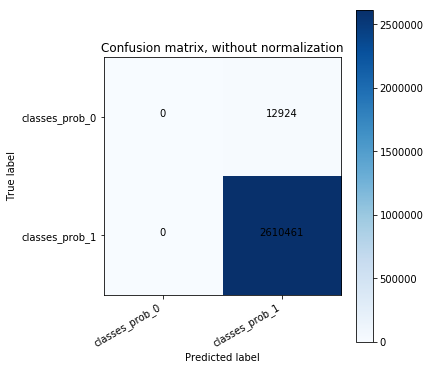

正则化混淆矩阵
[[0. 1.]
 [0. 1.]]


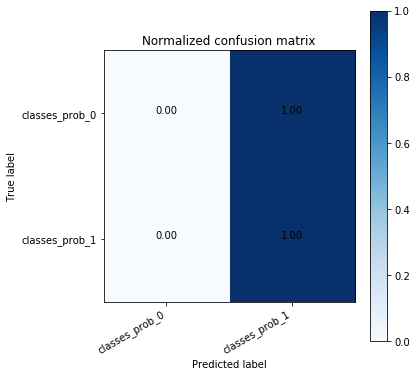

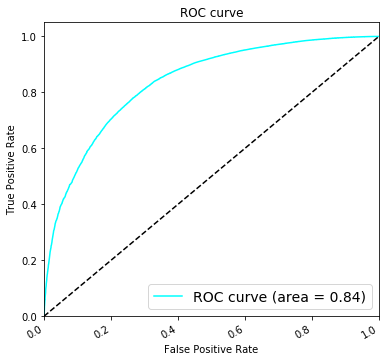

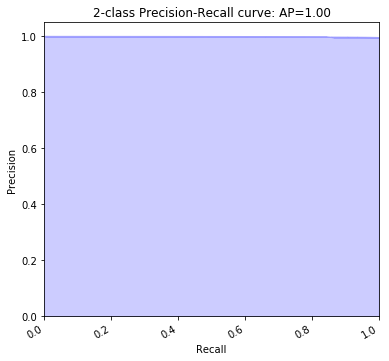

In [4]:
# 本代码由可视化策略环境自动生成 2019年5月12日 07:58
# 本代码单元只能在可视化模式下编辑。您也可以拷贝代码，粘贴到新建的代码单元或者策略，然后修改。


# 回测引擎：每日数据处理函数，每天执行一次
def m19_handle_data_bigquant_run(context, data):
    # 按日期过滤得到今日的预测数据
    ranker_prediction = context.ranker_prediction[
        context.ranker_prediction.date == data.current_dt.strftime('%Y-%m-%d')]

    # 1. 资金分配
    # 平均持仓时间是hold_days，每日都将买入股票，每日预期使用 1/hold_days 的资金
    # 实际操作中，会存在一定的买入误差，所以在前hold_days天，等量使用资金；之后，尽量使用剩余资金（这里设置最多用等量的1.5倍）
    is_staging = context.trading_day_index < context.options['hold_days'] # 是否在建仓期间（前 hold_days 天）
    cash_avg = context.portfolio.portfolio_value / context.options['hold_days']
    cash_for_buy = min(context.portfolio.cash, (1 if is_staging else 1.5) * cash_avg)
    cash_for_sell = cash_avg - (context.portfolio.cash - cash_for_buy)
    positions = {e.symbol: p.amount * p.last_sale_price
                 for e, p in context.portfolio.positions.items()}

    # 2. 生成卖出订单：hold_days天之后才开始卖出；对持仓的股票，按机器学习算法预测的排序末位淘汰
    if not is_staging and cash_for_sell > 0:
        equities = {e.symbol: e for e, p in context.portfolio.positions.items()}
        instruments = list(reversed(list(ranker_prediction.instrument[ranker_prediction.instrument.apply(
                lambda x: x in equities)]))

        for instrument in instruments:
            context.order_target(context.symbol(instrument), 0)
            cash_for_sell -= positions[instrument]
            if cash_for_sell <= 0:
                break

    # 3. 生成买入订单：按机器学习算法预测的排序，买入前面的stock_count只股票
    buy_cash_weights = context.stock_weights
    buy_instruments = list(ranker_prediction.instrument[:len(buy_cash_weights)])
    max_cash_per_instrument = context.portfolio.portfolio_value * context.max_cash_per_instrument
    for i, instrument in enumerate(buy_instruments):
        cash = cash_for_buy * buy_cash_weights[i]
        if cash > max_cash_per_instrument - positions.get(instrument, 0):
            # 确保股票持仓量不会超过每次股票最大的占用资金量
            cash = max_cash_per_instrument - positions.get(instrument, 0)
        if cash > 0:
            context.order_value(context.symbol(instrument), cash)

# 回测引擎：准备数据，只执行一次
def m19_prepare_bigquant_run(context):
    pass

# 回测引擎：初始化函数，只执行一次
def m19_initialize_bigquant_run(context):
    # 加载预测数据
    context.ranker_prediction = context.options['data'].read_df()

    # 系统已经设置了默认的交易手续费和滑点，要修改手续费可使用如下函数
    context.set_commission(PerOrder(buy_cost=0.0003, sell_cost=0.0013, min_cost=5))
    # 预测数据，通过options传入进来，使用 read_df 函数，加载到内存 (DataFrame)
    # 设置买入的股票数量，这里买入预测股票列表排名靠前的5只
    stock_count = 5
    # 每只的股票的权重，如下的权重分配会使得靠前的股票分配多一点的资金，[0.339160, 0.213986, 0.169580, ..]
    context.stock_weights = T.norm([1 / math.log(i + 2) for i in range(0, stock_count)])
    # 设置每只股票占用的最大资金比例
    context.max_cash_per_instrument = 0.2
    context.options['hold_days'] = 5


m1 = M.instruments.v2(
    start_date='2010-01-01',
    end_date='2015-01-01',
    market='CN_STOCK_A',
    instrument_list='',
    max_count=0
)

m2 = M.advanced_auto_labeler.v2(
    instruments=m1.data,
    label_expr="""# #号开始的表示注释
# 0. 每行一个，顺序执行，从第二个开始，可以使用label字段
# 1. 可用数据字段见 https://bigquant.com/docs/data_history_data.html
#   添加benchmark_前缀，可使用对应的benchmark数据
# 2. 可用操作符和函数见 `表达式引擎 <https://bigquant.com/docs/big_expr.html>`_

# 计算收益：未来5日收益率大于5%就标注为1类，否则为0类
where(shift(close, -5) / shift(open, -1)>0.05,1,0)
""",
    start_date='',
    end_date='',
    benchmark='000300.SHA',
    drop_na_label=True,
    cast_label_int=True
)

m3 = M.input_features.v1(
    features="""# #号开始的表示注释
# 多个特征，每行一个，可以包含基础特征和衍生特征
return_5
return_10
return_20
avg_amount_0/avg_amount_5
avg_amount_5/avg_amount_20
rank_avg_amount_0/rank_avg_amount_5
rank_avg_amount_5/rank_avg_amount_10
rank_return_0
rank_return_5
rank_return_10
rank_return_0/rank_return_5
rank_return_5/rank_return_10
pe_ttm_0
"""
)

m15 = M.general_feature_extractor.v7(
    instruments=m1.data,
    features=m3.data,
    start_date='',
    end_date='',
    before_start_days=0
)

m16 = M.derived_feature_extractor.v3(
    input_data=m15.data,
    features=m3.data,
    date_col='date',
    instrument_col='instrument',
    drop_na=False,
    remove_extra_columns=False
)

m7 = M.join.v3(
    data1=m2.data,
    data2=m16.data,
    on='date,instrument',
    how='inner',
    sort=False
)

m13 = M.dropnan.v1(
    input_data=m7.data
)

m4 = M.random_forest_classifier.v1(
    training_ds=m13.data,
    features=m3.data,
    predict_ds=m13.data,
    iterations=5,
    feature_fraction=1,
    max_depth=10,
    min_samples_per_leaf=200,
    key_cols='date,instrument',
    workers=1,
    other_train_parameters={}
)

m19 = M.trade.v4(
    instruments=m1.data,
    options_data=m4.predictions,
    start_date='',
    end_date='',
    handle_data=m19_handle_data_bigquant_run,
    prepare=m19_prepare_bigquant_run,
    initialize=m19_initialize_bigquant_run,
    volume_limit=0.025,
    order_price_field_buy='open',
    order_price_field_sell='close',
    capital_base=1000000,
    auto_cancel_non_tradable_orders=True,
    data_frequency='daily',
    price_type='后复权',
    product_type='股票',
    plot_charts=True,
    backtest_only=False,
    benchmark='000300.SHA'
)

m5 = M.metrics_classification.v1(
    predictions=m4.predictions,
    confusion_matrix=True,
    normal_confusion_matrix=True,
    ROC_curve=True,
    precision_recall_curve=True,
    max_size=30
)
